In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import yfinance as yf
import math
from statsmodels.tsa import stattools
from statsmodels.tsa import arima_model

In [15]:
data = pd.read_csv('FAANG.csv',parse_dates=True)
data.index = pd.to_datetime(data.Date)
data.drop('Date',axis=1,inplace=True)
data.dropna(inplace=True)
data

,FB,AMZN,AAPL,NFLX,GOOGL,FB_Ret,AMZN_Ret,AAPL_Ret,NFLX_Ret,GOOGL_Ret
Date,,,,,,,,,,
2012-05-21,34.03,218.11,17.29,10.25,307.36,-0.109861,0.019921,0.058140,0.026026,0.022829
2012-05-22,31.00,215.33,17.16,9.67,300.70,-0.089039,-0.012746,-0.007519,-0.056585,-0.021668
2012-05-23,32.00,217.28,17.58,10.27,305.04,0.032258,0.009056,0.024476,0.062048,0.014433
2012-05-24,33.03,215.24,17.42,10.04,302.13,0.032188,-0.009389,-0.009101,-0.022395,-0.009540
2012-05-25,31.91,212.89,17.32,10.03,296.06,-0.033909,-0.010918,-0.005741,-0.000996,-0.020091
...,...,...,...,...,...,...,...,...,...,...
2021-01-11,256.84,3114.21,128.98,499.10,1756.29,-0.040102,-0.021519,-0.023249,-0.022139,-0.023106
2021-01-12,251.09,3120.83,128.80,494.25,1737.43,-0.022387,0.002126,-0.001396,-0.009717,-0.010739
2021-01-13,251.64,3165.89,130.89,507.79,1747.25,0.002190,0.014438,0.016227,0.027395,0.005652


### Check ARCH Effect

In [16]:
def arch(stock,pq):
    ############## Split Data #######################
    train = data[stock]['2012':'2019']
    test = data[stock]['2020']
    stock_name = stock.replace('_Ret','')
    ############## Check Residue^2  #################
    model = arima_model.ARIMA(train,order = pq).fit()
    stdresid = model.resid/math.sqrt(model.sigma2)
    lbt = stattools.q_stat(stattools.acf(stdresid**2)[1:30],len(stdresid))
    wnNumber = lbt[1][-1]
    print('Ljung-Box p-value = %.5f'%(wnNumber))
    if wnNumber > 0.05:
        print('%s is a White Noise'%(stock_name))
    else:
        print('ARCH Effect Exists')
    ##############  ################################

In [17]:
arch('AAPL_Ret',(2,0,2))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Ljung-Box p-value = 0.00000
ARCH Effect Exists


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [18]:
arch('AMZN_Ret',(2,0,1))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Ljung-Box p-value = 0.00420
ARCH Effect Exists


### NEW TEST ARMA + GARCH
ARMA -> Model <br>
GARCH -> Volatility (e_t)<br>
y = a_0 + a1y_(t-1) + e_t <br>
AMZN ARMA -> AMZN = 0.0013 + 0.6299arL1 - 0.0416arL2 - 0.6351maL1

In [19]:
amzn_train = data['AMZN_Ret']['2012':'2019']
amzn_test = data['AMZN_Ret']['2020']
model = arima_model.ARIMA(amzn_train,order=(2,0,1)).fit()
model.summary()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               AMZN_Ret   No. Observations:                 1916
Model:                     ARMA(2, 1)   Log Likelihood                4943.415
Method:                       css-mle   S.D. of innovations              0.018
Date:                Sun, 17 Jan 2021   AIC                          -9876.830
Time:                        11:09:22   BIC                          -9849.040
Sample:                             0   HQIC                         -9866.604
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0013      0.000      3.484      0.000       0.001       0.002
ar.L1.AMZN_Ret     0.6299      0.285      2.209      0.027       0.071       1.189
ar.L2.AMZN_Ret    -0.0416      0.027     -1.554      0.120      -0.094       0.011
ma.L1.AMZN_Ret    -0.6351      0.285     -2.227      0.026      -1.194      -0.076
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8020           +0.0000j            1.8020            0.0000
AR.2           13.3341           +0.0000j           13.3341            0.0000
MA.1            1.5745           +0.0000j            1.5745            0.0000
-----------------------------------------------------------------------------
"""

In [20]:
model.forecast(len(amzn_test))[0]
stock_forecast = pd.DataFrame(model.forecast(len(amzn_test))[0])
stock_forecast.index=data['2020'].index
stock_forecast

,0
Date,
2020-01-02,0.001172
2020-01-03,0.001249
2020-01-06,0.001271
2020-01-07,0.001281
2020-01-08,0.001287
...,...
2020-12-24,0.001294
2020-12-28,0.001294
2020-12-29,0.001294


### GARCH
r_t = 0.00176 + e_t
e_t = sigma_t * u_t
sigma_t^2 = 0.000033720 + 0.1e_{t-1}^2 + 0.8sigma_{t-1}^2

In [21]:
import datetime as dt
import pandas_datareader.data as web
from arch import arch_model
AMZN_train = data['AMZN_Ret']['2012':'2019']
AMZN_test = data['AMZN_Ret']['2020']
AMZN = data['AMZN_Ret']
am = arch_model(AMZN)

In [22]:
split_date = dt.datetime(2020,1,2)
res = am.fit(last_obs=split_date)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1625500234.6985726
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4710.473386076303
Iteration:      3,   Func. Count:     28,   Neg. LLF: 6253393.6748918295
Iteration:      4,   Func. Count:     39,   Neg. LLF: -5035.557101111885
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5035.5571015675505
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 4


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003372. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [23]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:               AMZN_Ret   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                5035.56
Distribution:                  Normal   AIC:                          -10063.1
Method:            Maximum Likelihood   BIC:                          -10040.9
                                        No. Observations:                 1916
Date:                Sun, Jan 17 2021   Df Residuals:                     1912
Time:                        11:09:23   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.7610e-03  3.994e-04      4.409  1.040e-05 [9.781e-04,2.544e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.3720e-05  2.438e-06     13.830  1.677e-43 [2.894e-05,3.850e-05]
alpha[1]       0.1000  3.000e-02      3.334  8.562e-04   [4.122e-02,  0.159]
beta[1]        0.8000  2.384e-02     33.555 7.693e-247     [  0.753,  0.847]
============================================================================

Covariance estimator: robust
"""

<AxesSubplot:xlabel='Date'>

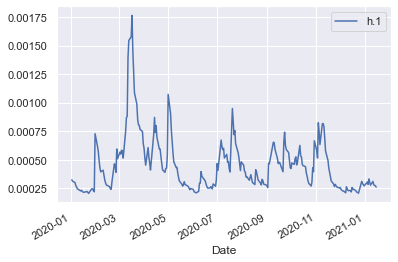

In [24]:
forecasts = res.forecast(horizon=1, start=split_date)
forecasts.variance[split_date:].plot()

In [25]:
f = forecasts.variance
f['2020']

,h.1
Date,
2020-01-02,0.000325
2020-01-03,0.000313
2020-01-06,0.000301
2020-01-07,0.000275
2020-01-08,0.000263
...,...
2020-12-24,0.000208
2020-12-28,0.000311
2020-12-29,0.000292


### Combine

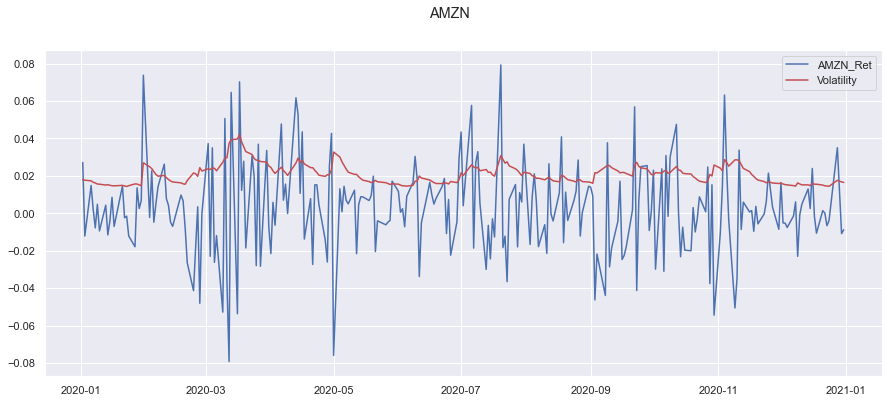

In [26]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot()
ax1.plot(AMZN_test,label='AMZN_Ret')
ax1.plot(np.sqrt(f['2020']),label='Volatility',color='r')
fig.suptitle('AMZN')
plt.legend()
#fig.savefig('AMZN_GARCH.png')